## Education 

The aim of this notebook is to clean and generate a composite income and education metric for gentrification

In [1]:
#import relevant packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
#os to load files
import os
import re

import warnings
warnings.filterwarnings('ignore')

#load all custom functions
from functions import *

In [2]:
#Define folder path
rel_folder_path='../data/raw/education'

#Create a list containing the names of all csv files in the folder (there are 11 csv files containing data from each year between 2010 and 2011)
education_csv_files = [f for f in os.listdir(rel_folder_path) if f.endswith('.csv')]

#instantiate an empty list to store all the dataframes obtain from csv files
edu_all=[]

#loop through each csv file name in the list and load each file as a pandas dataframe
for file in education_csv_files:
    filepath = os.path.join(rel_folder_path, file)
    df = pd.read_csv(filepath)
    edu_all.append(df)

#now we have a list where each item is a dataframe containing education information for each year (chronologically)

***
### Cleaning_Step_1: select relevant column, rename census tracts to match between the years and select only census tracts present in the permit dataset

`Note` : Column Namings and Codes changed between the years

Following review of the dataframes, it was indentified that the following columns are of interest to the study : 

***Years 2010-2014*** : [0-4]

* **'GEO_ID'** : contains `Census_Tract`
* **S1501_C01_014E** : contains `High_school_plus_over_25`
* **S1501_C01_015E** : contains `Bachelors_plus_over_25`

<br/>

***Years 2015-2021*** : [5-11]

* **'GEO_ID'** : contains `Census_Tract`
* **'S1501_C02_014E'** : contains `High_school_plus_over_25`
* **'S1501_C02_015E'** : contains `Bachelors_plus_over_25`

Create a following dictionary **`{column name: column description}`** which will be used to select and rename the columns of interest

In [3]:
#List of columns that are of interest for this investigation
edu_col_di_a={'GEO_ID':'Census_Tract','S1501_C01_014E':'High_school_plus_over_25','S1501_C01_015E':'Bachelors_plus_over_25'}
edu_col_di_b={'GEO_ID':'Census_Tract','S1501_C02_014E':'High_school_plus_over_25','S1501_C02_015E':'Bachelors_plus_over_25'}

* Using **census_column_selector** function, select and rename the required columns
  * `edu_col_di` dictionary passes information regarding which columns to select and defines the new names

In [4]:
#use list comprehension to apply the function census_column_selector to each DataFrame in the list income_all
#set remove_first_row to True to remove the fisrt row [0] as it contains column description not the actual data

edu_all_temp=[census_column_selector(df,edu_col_di_a,remove_first_row=True) if i<5 else census_column_selector(df,edu_col_di_b,remove_first_row=True) for i,df in enumerate(edu_all)]

* Load files needed for census tract matching

In [5]:
#dictionary to ensure census tracts between the years match
tract_changes=joblib.load('../data/interim/tract_changes.pkl')

* Copying cleaning steps from the notebook *2.INCOME_CLEANING+EDA* to obtain `relevant census tract numbers`

In [6]:
#Load a dataframe with all the census tracts and their respective coordiantes from the current Permit Dataframe
ct_coord=joblib.load('../data/interim/ct_coord.pkl').reset_index(drop=True)
#Reformat to obtain a set of unique census tracts
ct_coord=ct_coord.groupby('CENSUS_TRACT').mean().reset_index()
permit_tracts=set(ct_coord['CENSUS_TRACT'])

#Rename using tract_changes dictionary
permit_tracts_updated = [tract_changes.get(item, item) for item in permit_tracts]

* The purpose of **census_tract_cleaning** function is to `replace ct numbers, merge rows with the same ct and select relevant rows`
* Apply function **census_tract_cleaning**, using the following arguments:
  * `df` current dataframe
  * `tract_changes` dictionary to replace old census tract numbers
  * `permit_tracts_updated` - list of census tracts relevant to the study (taken from the permit dataset and reformatted accordingly)

In [7]:
#using list comprehension apply the function to all the dataframes in the list and generate a list with the updated dataframes
edu_all_temp2=[census_tract_cleaning(df,tract_changes,permit_tracts_updated) for df in edu_all_temp]

***
### Cleaning_Step_2: merging the small census tracts (less than 600 households) together and select only census tract number present in the income dataset

* Merge small census tracts together using the dictionary `closest_di_result` generated in the income cleaning notebook

In [8]:
#dictionary to merge the small census tracts together
closest_di_result=joblib.load('../data/interim/tract_merger.pkl')

#a set of census tract numbers present in the income dataset
tracts_relevant=set(pd.read_csv('../data/clean/income_cleaned.csv')['Census_Tract'])

#using census_tract_cleaning function again to replace census tract numbers and groupby the same ones
edu_all_temp3=[census_tract_cleaning(df,closest_di_result,tracts_relevant) for df in edu_all_temp2]

In [9]:
edu_all_temp3[0]

,Census_Tract,High_school_plus_over_25,Bachelors_plus_over_25
0,10100,90.90,35.4
1,10201,80.10,32.4
2,10202,83.70,32.3
3,10300,76.40,31.0
4,10400,94.30,61.8
...,...,...,...
720,843700,93.80,55.2
721,843800,69.20,5.6
722,843900,82.20,34.2
723,844600,89.30,12.0


***
### CONCATENATING: merge the dataframes for individual years together into one dataframe

* Step 1: Add year suffix to each column apart from census_tract

In [10]:
# Create an empty list to store the DataFrames with year suffices added to the columns
edu_all_naming=[]

# Set the initial year to 2010
year=2010
# Loop through each DataFrame in income_all_temp2
for df in edu_all_temp3:
    # Extract the 'Census_Tract' column and concatenate it with the other columns, which are suffixed with the current year
    # The resulting DataFrame is appended to the income_all_new list
    edu_all_naming.append(pd.concat([df['Census_Tract'],df.drop(columns='Census_Tract').add_suffix('_').add_suffix(str(year))],axis=1))
    #Increment Year
    year+=1

* Before using `concat`, check if Census Tract Columns Align in all data frames

In [11]:
# Extract the 'Census_Tract' column from the first DataFrame in income_all_new
test_col=edu_all_naming[0]['Census_Tract']

# Loop through each DataFrame in income_all_new
for df in edu_all_naming:
    # Check if all values in the 'Census_Tract' column of the current DataFrame match those of the first DataFrame
    if all(df['Census_Tract']==test_col):
        print('EQUAL')
    else:
        print('ERROR')

EQUAL
EQUAL
EQUAL
EQUAL
EQUAL
EQUAL
EQUAL
EQUAL
EQUAL
EQUAL
EQUAL
EQUAL


In [12]:
edu_all_naming[0]

,Census_Tract,High_school_plus_over_25_2010,Bachelors_plus_over_25_2010
0,10100,90.90,35.4
1,10201,80.10,32.4
2,10202,83.70,32.3
3,10300,76.40,31.0
4,10400,94.30,61.8
...,...,...,...
720,843700,93.80,55.2
721,843800,69.20,5.6
722,843900,82.20,34.2
723,844600,89.30,12.0


* Step 2: Concatenate dataframes

In [13]:
#Before concatenating drop Census Tract column from all dataframes apart from the first to avoid duplicates
edu_all_pre_concat=[df.drop(columns='Census_Tract') if i>0 else df for i,df in enumerate(edu_all_naming)]

#concatenate and preview the result
edu_merged=pd.concat(edu_all_pre_concat,axis=1)
edu_merged

,Census_Tract,High_school_plus_over_25_2010,Bachelors_plus_over_25_2010,High_school_plus_over_25_2011,Bachelors_plus_over_25_2011,High_school_plus_over_25_2012,Bachelors_plus_over_25_2012,High_school_plus_over_25_2013,Bachelors_plus_over_25_2013,High_school_plus_over_25_2014,...,High_school_plus_over_25_2017,Bachelors_plus_over_25_2017,High_school_plus_over_25_2018,Bachelors_plus_over_25_2018,High_school_plus_over_25_2019,Bachelors_plus_over_25_2019,High_school_plus_over_25_2020,Bachelors_plus_over_25_2020,High_school_plus_over_25_2021,Bachelors_plus_over_25_2021
0,10100,90.90,35.4,95.6,38.6,NaN,NaN,87.4,29.00,82.3,...,88.80,34.90,88.3,48.00,85.5,28.4,87.9,51.1,85.6,50.1
1,10201,80.10,32.4,80.1,32.0,NaN,NaN,82.4,34.50,82.4,...,80.10,31.90,80.3,32.20,85.7,39.2,85.8,32.8,84.1,34.7
2,10202,83.70,32.3,82.4,33.9,NaN,NaN,83.0,34.30,76.0,...,83.00,36.70,79.0,33.10,85.2,30.9,81.2,36.4,83.0,36.2
3,10300,76.40,31.0,77.2,32.3,NaN,NaN,78.8,30.30,79.2,...,83.00,36.20,89.8,40.40,83.1,31.5,87.1,43.5,88.8,44.5
4,10400,94.30,61.8,96.8,68.0,NaN,NaN,92.3,59.30,90.1,...,99.00,68.20,96.2,64.70,92.5,49.7,97.1,59.0,96.6,59.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,843700,93.80,55.2,93.8,58.7,NaN,NaN,94.8,63.60,92.3,...,90.50,52.50,83.8,59.00,96.8,58.4,87.9,68.9,87.5,67.5
721,843800,69.20,5.6,67.4,3.1,NaN,NaN,71.1,8.40,77.6,...,85.00,7.90,87.7,11.60,69.4,8.3,81.3,13.2,89.6,15.5
722,843900,82.20,34.2,81.9,34.9,NaN,NaN,84.0,34.50,87.3,...,85.30,36.50,86.1,35.20,82.9,28.7,81.1,36.6,81.1,39.7
723,844600,89.30,12.0,89.5,14.8,NaN,NaN,83.6,15.90,73.7,...,89.55,12.85,90.7,24.85,73.3,6.6,90.0,24.0,86.9,18.5


In [14]:
overview(edu_merged)

The dataframe shape is (725, 25)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
Census_Tract,int64,0,0.000000,10100.0,844700.00,242600.0
High_school_plus_over_25_2010,float64,0,0.000000,90.9,82.45,77.5
Bachelors_plus_over_25_2010,float64,0,0.000000,35.4,8.10,39.8
High_school_plus_over_25_2011,float64,0,0.000000,95.6,78.50,82.1
Bachelors_plus_over_25_2011,float64,0,0.000000,38.6,11.30,41.6
High_school_plus_over_25_2012,float64,725,100.000000,NaN,NaN,NaN
Bachelors_plus_over_25_2012,float64,725,100.000000,NaN,NaN,NaN
High_school_plus_over_25_2013,float64,0,0.000000,87.4,78.40,81.0
Bachelors_plus_over_25_2013,float64,0,0.000000,29.0,5.65,44.0


### Null Values

In [15]:
edu_merged[edu_merged['Bachelors_plus_over_25_2010'].isna()]

,Census_Tract,High_school_plus_over_25_2010,Bachelors_plus_over_25_2010,High_school_plus_over_25_2011,Bachelors_plus_over_25_2011,High_school_plus_over_25_2012,Bachelors_plus_over_25_2012,High_school_plus_over_25_2013,Bachelors_plus_over_25_2013,High_school_plus_over_25_2014,...,High_school_plus_over_25_2017,Bachelors_plus_over_25_2017,High_school_plus_over_25_2018,Bachelors_plus_over_25_2018,High_school_plus_over_25_2019,Bachelors_plus_over_25_2019,High_school_plus_over_25_2020,Bachelors_plus_over_25_2020,High_school_plus_over_25_2021,Bachelors_plus_over_25_2021


In [16]:
edu_merged=edu_merged.fillna(1.9)

***
## EDA

### Step_1_Histograms: average for all years for each census tract

* Plot histograms for **High_school_plus_over_25** and **Bachelors_plus_over_25**

High School Diploma min and max are 37.12 and 91.71
The High School Diploma Distribution range is 54.59


Bachelors Diploma min and max are 3.01 and 84.84
The Bachelors Diploma Distribution range is 81.83


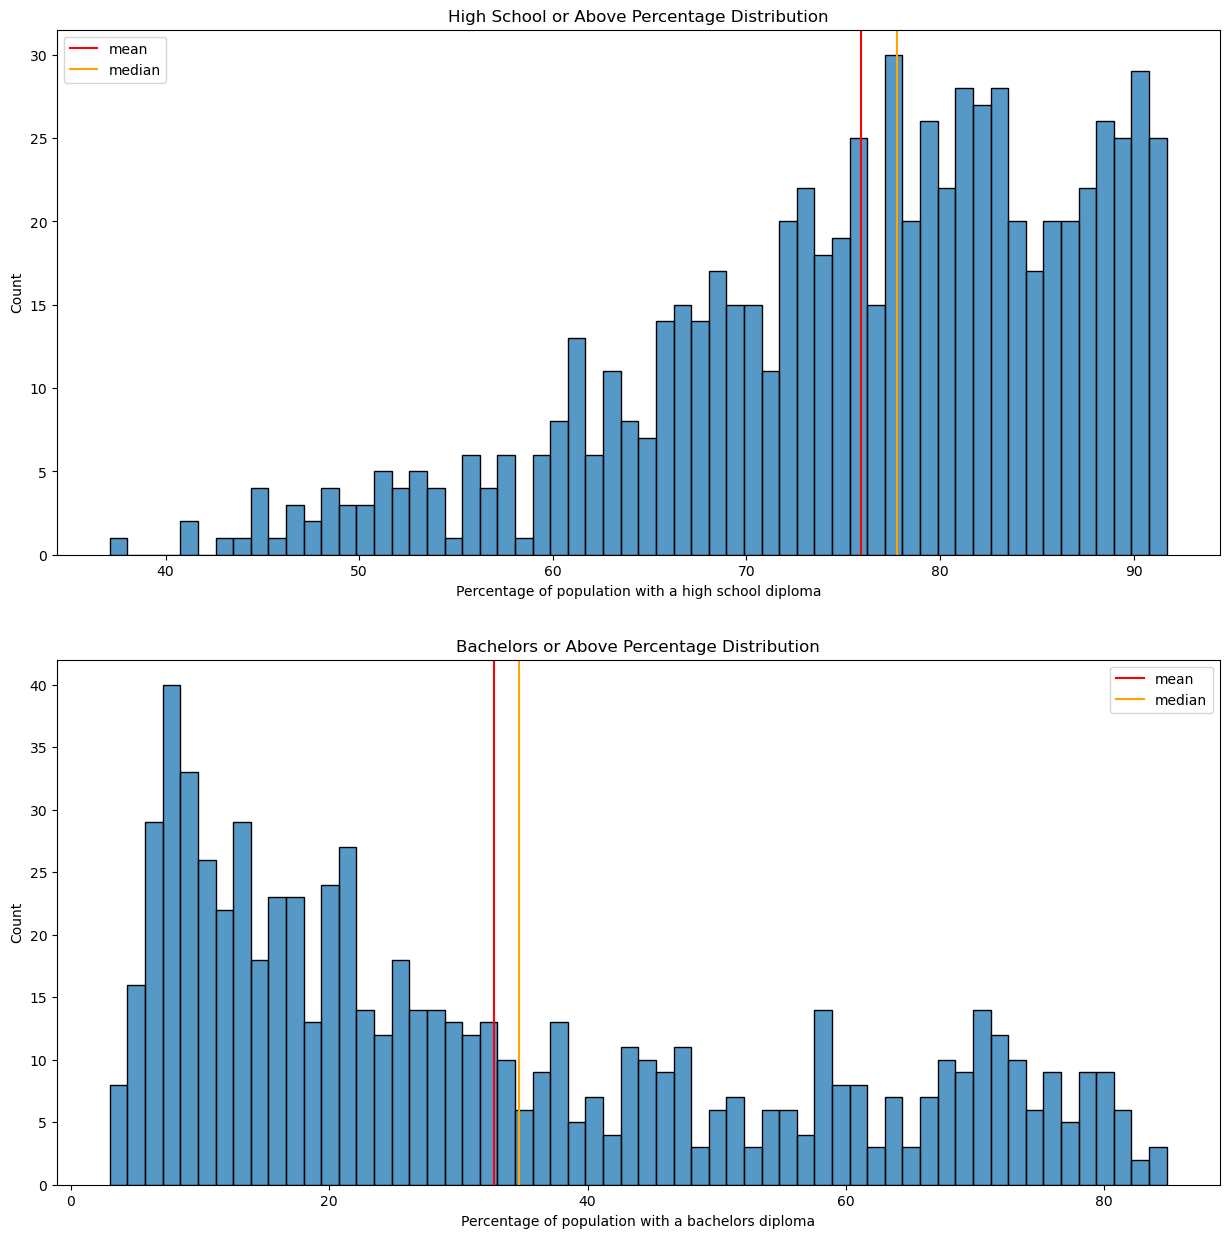

In [17]:
#Select high school and bachelors columns using get_columns_with_regex function
bachelors=get_columns_with_regex(edu_merged,'Bachelors')
school=get_columns_with_regex(edu_merged,'school')

#set up suplots
fig, ax= plt.subplots(2,1,figsize=(15,15))

#plot 1 high school distribution
plt.subplot(2,1,1)
sns.histplot(data=school.mean(axis=1),bins=60)
plt.axvline(school.mean(axis=1).mean(),color='red',label='mean')
plt.axvline(school.mean(axis=1).median(),color='orange',label='median')

plt.title('High School or Above Percentage Distribution')
plt.xlabel('Percentage of population with a high school diploma')

plt.legend()

print(f'High School Diploma min and max are {min(school.mean(axis=1)):.2f} and {max(school.mean(axis=1)):.2f}')
print(f'The High School Diploma Distribution range is {max(school.mean(axis=1))-min(school.mean(axis=1)):.2f}')

#plot 2 bachelors distribution
plt.subplot(2,1,2)
sns.histplot(data=bachelors.mean(axis=1),bins=60)
plt.axvline(bachelors.mean(axis=1).mean(),color='red',label='mean')
plt.axvline(bachelors.mean().median(),color='orange',label='median')

plt.title('Bachelors or Above Percentage Distribution')
plt.xlabel('Percentage of population with a bachelors diploma')

plt.legend()

print('\n')
print(f'Bachelors Diploma min and max are {min(bachelors.mean(axis=1)):.2f} and {max(bachelors.mean(axis=1)):.2f}')
print(f'The Bachelors Diploma Distribution range is {max(bachelors.mean(axis=1))-min(bachelors.mean(axis=1)):.2f}')

plt.show()

* As expected, the mean and median for high school distribution are higher than for the bachelors degree
* The distribution of the bachelors degrees is 89.33 points wide, while the distribution of high school diplomas is only 59.36 points wide
* It is expected that bachelors degree would be a better metric for gentrification

### Step_2_Lineplots: Overall Change

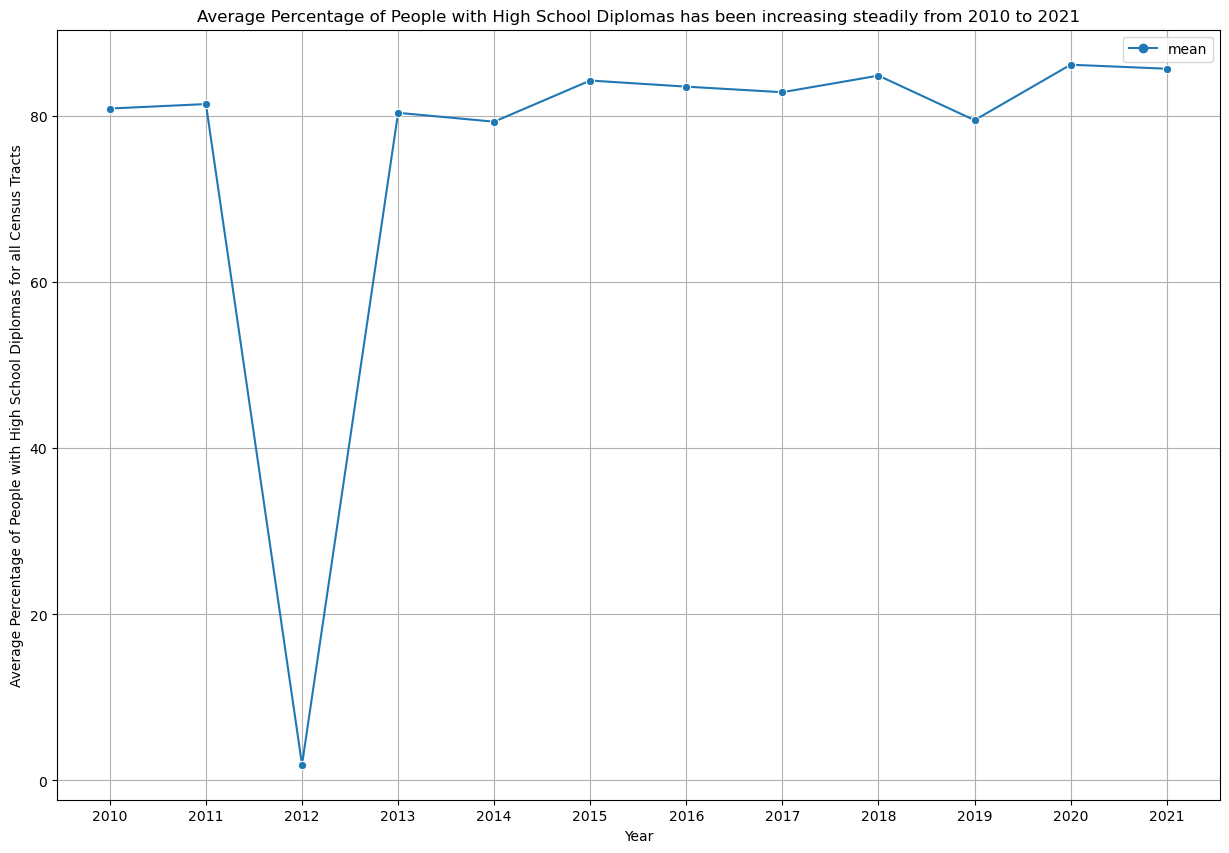

In [18]:
fig, ax = plt.subplots(figsize=(15,10))

sns.lineplot(data=pd.DataFrame(school.mean(axis=0).rename('mean')),markers=True)
plt.title('Average Percentage of People with High School Diplomas has been increasing steadily from 2010 to 2021')
plt.xlabel('Year')
plt.ylabel('Average Percentage of People with High School Diplomas for all Census Tracts')

plt.xticks(range(0, len(school.columns)), [str(year) for year in range(2010,2022)])
plt.grid(True)
plt.show();

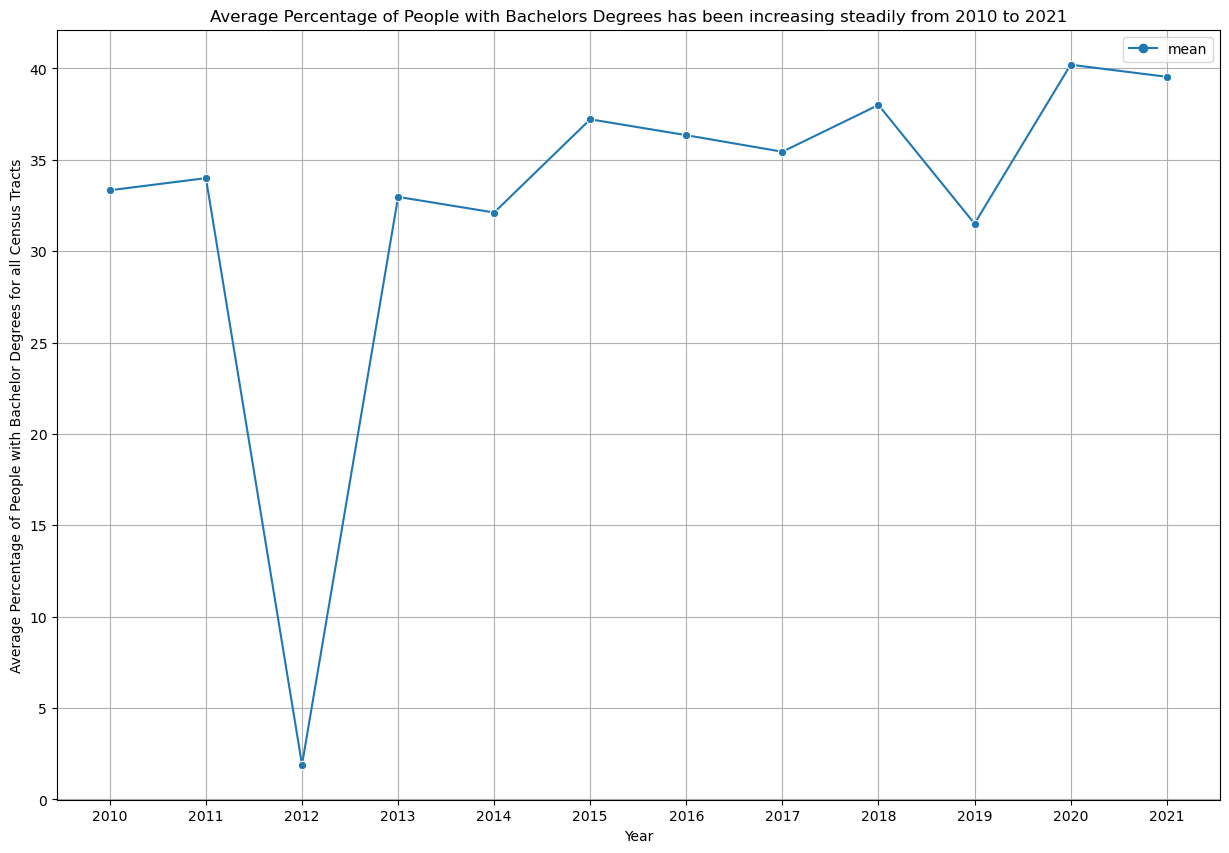

In [19]:
fig, ax = plt.subplots(figsize=(15,10))

sns.lineplot(data=pd.DataFrame(bachelors.mean(axis=0).rename('mean')),markers=True)
plt.title('Average Percentage of People with Bachelors Degrees has been increasing steadily from 2010 to 2021')
plt.xlabel('Year')
plt.ylabel('Average Percentage of People with Bachelor Degrees for all Census Tracts')

plt.xticks(range(0, len(school.columns)), [str(year) for year in range(2010,2022)])
plt.grid(True)
plt.show();

### Step_3_Lineplots: Change for selected census tracts

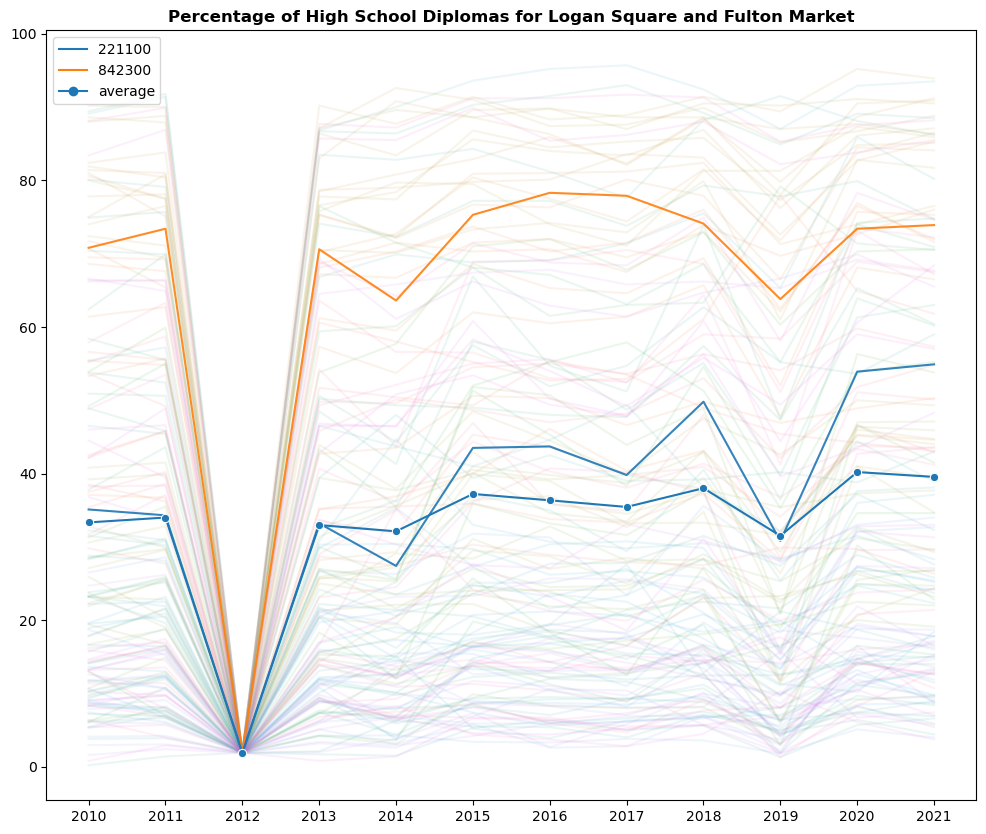

In [20]:
#Consider some of the Chicago Districts that are known to have been gentrified, such as 842300 and 221100
df_temp=get_columns_with_regex(edu_merged.set_index('Census_Tract'),'Bachelors')

fig, ax = plt.subplots(figsize=(12,10))

sns.lineplot(data=df_temp.iloc[range(0,df_temp.shape[0],5)].T,dashes=False,alpha=0.1,legend=False)
sns.lineplot(data=df_temp[df_temp.index.isin([842300,221100])].T,dashes=False,alpha=0.9)
sns.lineplot(data=pd.DataFrame(df_temp.mean(axis=0).T.rename('average')),markers=True,dashes=True)

#select years from the column names by slicicng the last 4 characters
li=[(i[-4::]) for i in df_temp.columns]
ax.set_xticklabels(li)
plt.title('Percentage of High School Diplomas for Logan Square and Fulton Market',fontsize=12,fontweight='bold',wrap=True)
plt.show()

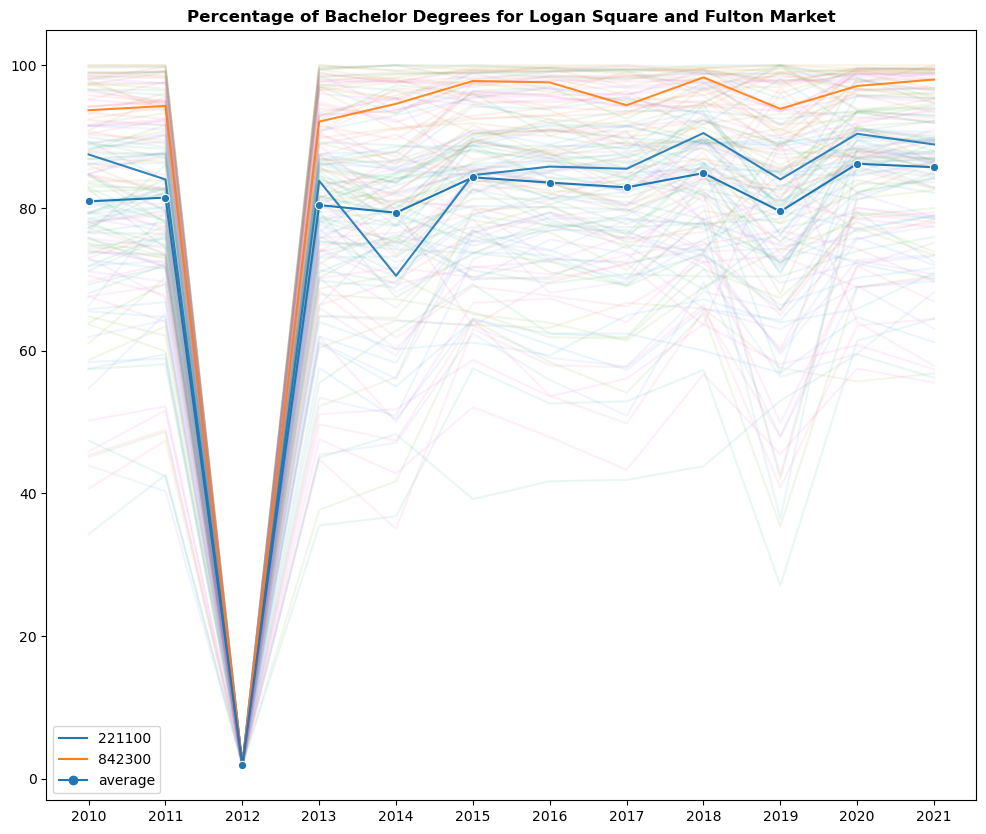

In [21]:
#Consider some of the Chicago Districts that are known to have been gentrified, such as 842300 and 221100
df_temp=get_columns_with_regex(edu_merged.set_index('Census_Tract'),'school')

fig, ax = plt.subplots(figsize=(12,10))

sns.lineplot(data=df_temp.iloc[range(0,df_temp.shape[0],5)].T,dashes=False,alpha=0.1,legend=False)
sns.lineplot(data=df_temp[df_temp.index.isin([842300,221100])].T,dashes=False,alpha=0.9)
sns.lineplot(data=pd.DataFrame(df_temp.mean(axis=0).T.rename('average')),markers=True,dashes=True)

#select years from the column names by slicicng the last 4 characters
li=[(i[-4::]) for i in df_temp.columns]
ax.set_xticklabels(li)
plt.title('Percentage of Bachelor Degrees for Logan Square and Fulton Market',fontsize=12,fontweight='bold',wrap=True)
plt.show()

* Logan Sqaure (221100) experienced greater change in the education levels

### Step_4_Lineplots: Change for each census tract over the years

In [22]:
help(change_plot)

Help on function change_plot in module functions:

change_plot(df, year_start, year_end, mode='absolute', ranking='max', reg_ex='Mean', perc_power=2)
    Use:
        This function plots the change in income over a period between 2 years, and filters for census tracts that meet certain criteria.
    
    Inputs:
        df: dataframe containing income data
        year_start: start year for the income comparison
        year_end: end year for the income comparison
        mode: type of income change to evaluate ['absolute','percentage','combined_log','combined_power'] (default: 'absolute')
        ranking: specifies whether to filter the top or bottom census tracts ['min',''max'] (default: 'max')
        reg_ex: regular expression to use for column selection ['Mean','Median'], (default: 'Mean')
        perc_power: power to raise the percentage difference to - only for mode=='combined_power' (default: 2)
    
    
    Output:
        A line plot showing the change in income for census t

NameError: name 'sns' is not defined

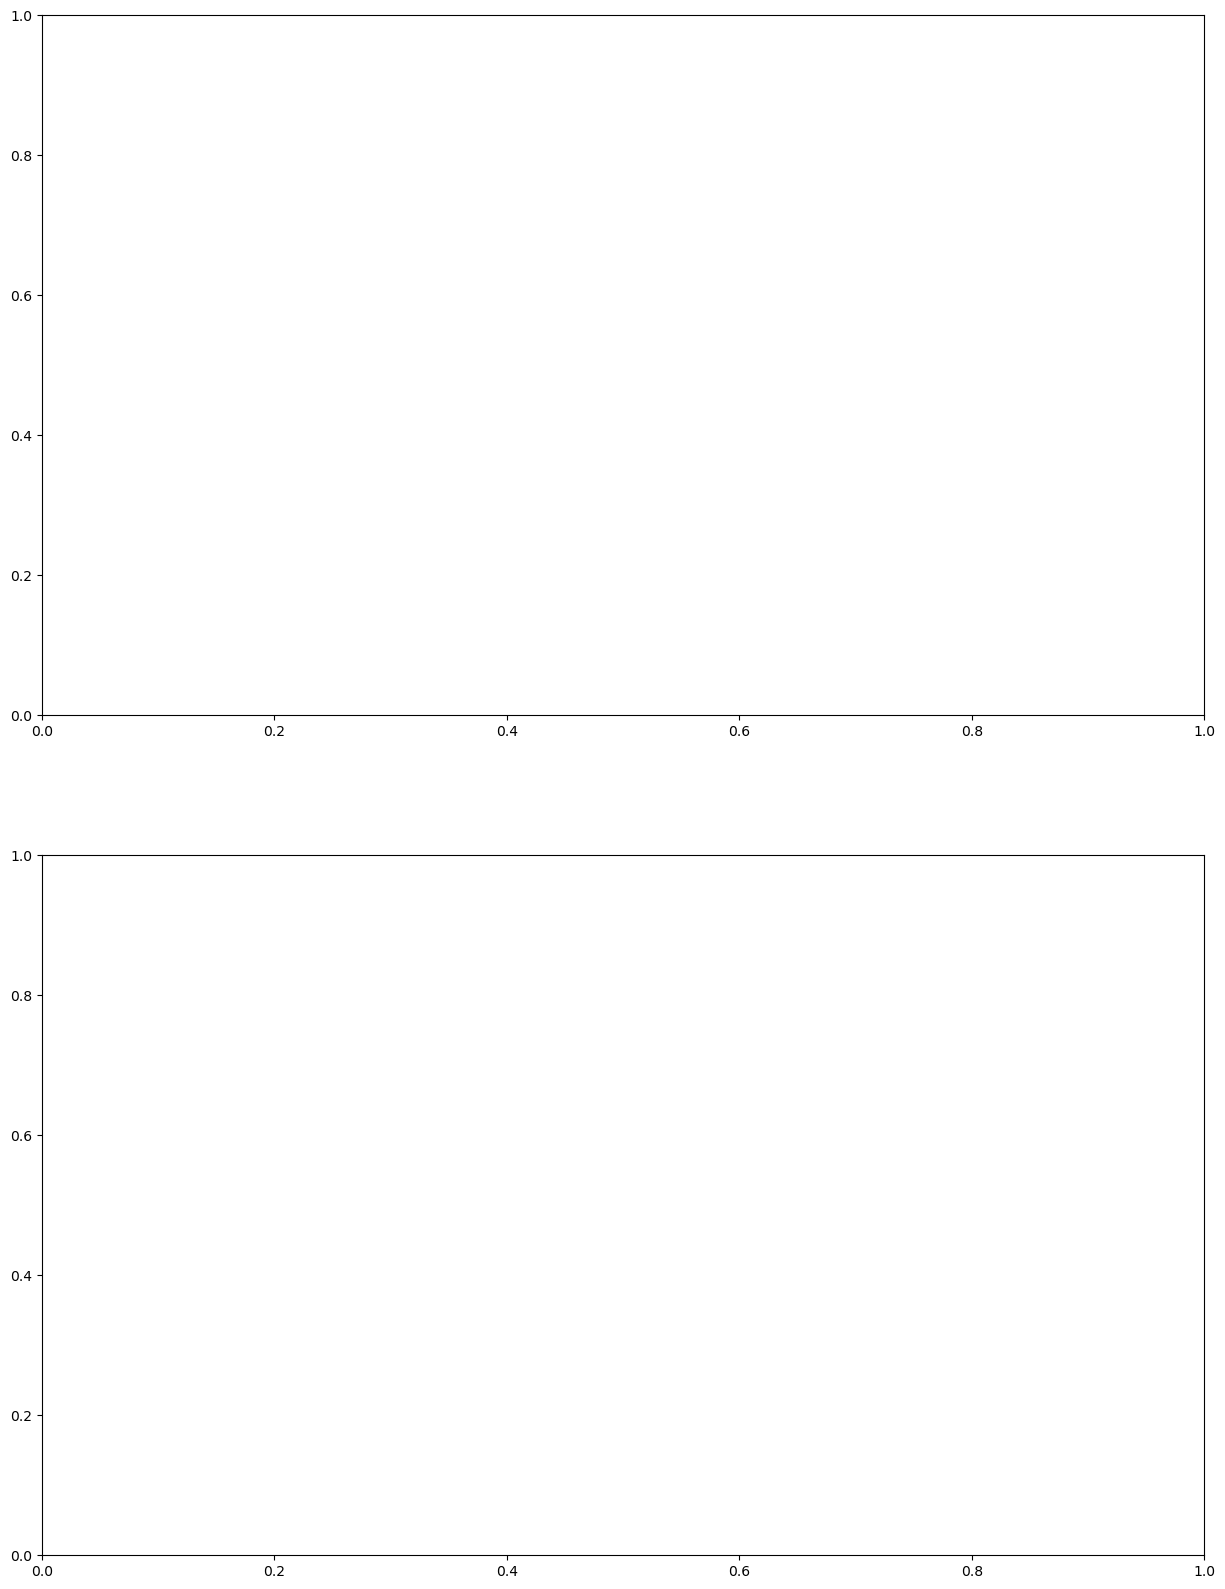

In [23]:
fig, ax = plt.subplots(2,1, figsize=(15,20))

plt.subplot(2,1,1)
change_plot(edu_merged, 2010,2021,mode='absolute',ranking='max',reg_ex='school')
plt.title('10 Census Tracts with the greatest ABSOLUTE change in the percentage of population with HIGH SCHOOL degrees',fontsize=12,fontweight='bold',wrap=True)

plt.subplot(2,1,2)
change_plot(edu_merged, 2010,2021,mode='percentage',ranking='max',reg_ex='school')
plt.title('10 Census Tracts with the greatest PERCENTAGE change in the percentage of population with HIGH SCHOOL degrees',fontsize=12,fontweight='bold',wrap=True)

plt.show()

* Difficult to find a good change metric for high school diploma percentage change, as very few tracts that crossed the average line are being selected
* For gentrification to occur, high school education levels should be above the city average, but ones the percentage levels are high, the subsequent change is minor -> difficult to pick up on
* Let's consider the changes in the percentage of population with bachelor degrees

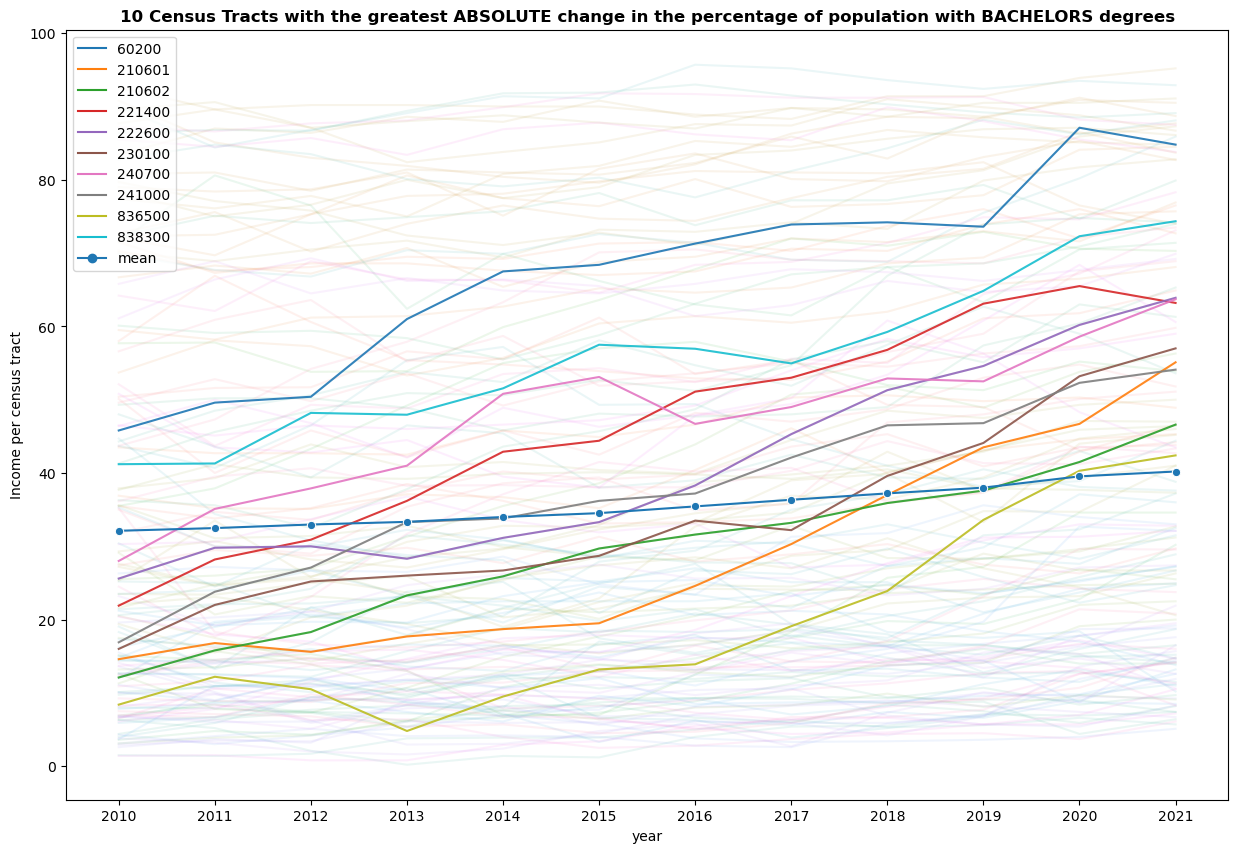

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,10))

plt.subplot(1,1,1)
change_plot(edu_merged, 2010,2021,mode='absolute',ranking='max',reg_ex='Bachelor')
plt.title('10 Census Tracts with the greatest ABSOLUTE change in the percentage of population with BACHELORS degrees',fontsize=12,fontweight='bold',wrap=True)

plt.show()

* Tracts with the **highest absolute change** in bachelor degrees tend to cross the city average line
  * which is a good indicator of gentrification occuring
* Let's now preview this information on a map to understand the geogrpahic distribution

In [ ]:
#Load a dataframe with all the census tracts and their respective coordiantes from the current Permit Dataframe
ct_coord=joblib.load('../data/interim/ct_coord.pkl').reset_index(drop=True)

ct_coord=ct_coord.groupby('CENSUS_TRACT').mean().reset_index()

permit_tracts=set(ct_coord['CENSUS_TRACT'])

In [ ]:
abs_change_remap.isna().sum()

1

In [ ]:
import plotly.express as px

abs_change=(edu_merged['Bachelors_plus_over_25_2021']-edu_merged['Bachelors_plus_over_25_2010'])*np.log(edu_merged['Bachelors_plus_over_25_2021']/edu_merged['Bachelors_plus_over_25_2010'])
abs_change_remap=abs_change+abs(min(abs_change))

fig = px.scatter_mapbox(coord(edu_merged,ct_coord), lat="LATITUDE", lon="LONGITUDE",color=abs_change_remap,size=list(abs_change_remap), size_max=15, zoom=10, mapbox_style="carto-positron")

fig.update_layout(width=1500,height=1000)

fig.show()

* drop high school columns as it was established that using the absolute change in the bachelor degrees is more effective

In [24]:
edu_df=edu_merged.drop(columns=get_columns_with_regex(edu_merged, 'school'))

---
## load_income_data

In [25]:
income_df=pd.read_csv('../data/clean/income_cleaned.csv',index_col=0)
income_df

,Census_Tract,Mean_Income_2010,Mean_Income_2011,Mean_Income_2012,Mean_Income_2013,Mean_Income_2014,Mean_Income_2015,Mean_Income_2016,Mean_Income_2017,Mean_Income_2018,Mean_Income_2019,Mean_Income_2020,Mean_Income_2021
0,10100.0,51153.0,46073.0,45816.0,46395.33,46010.33,46617.67,46764.00,48697.67,51520.00,54040.33,62139.67,66686.67
1,10201.0,52591.0,54747.0,52577.0,53617.33,55840.00,57720.33,59653.67,58489.00,59625.00,57766.33,57301.33,57490.00
2,10202.0,47699.0,50757.0,51070.0,49787.67,47217.67,44778.00,43688.00,44841.33,46796.00,49059.00,52760.00,55745.67
3,10300.0,57075.0,57791.0,54026.0,54951.33,56186.33,56623.33,60169.00,61818.33,66695.00,66826.33,66718.33,67228.33
4,10400.0,58457.0,60445.0,60477.0,61379.67,60928.33,59038.67,56360.00,54660.00,54469.00,54302.00,54183.67,55593.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,843700.0,81933.0,136092.0,136926.0,135590.33,138564.67,144525.67,149488.33,153845.67,164966.33,179349.67,194896.00,202775.33
721,843800.0,51766.0,50963.0,42772.0,44309.00,41058.67,42415.67,44293.00,47743.00,46998.67,47478.67,54035.33,55294.33
722,843900.0,48229.0,45613.0,52815.0,47744.33,47987.00,45130.00,44466.33,43928.67,45237.00,47438.00,51405.67,55018.67
723,844600.0,44142.0,44861.0,47701.0,38814.50,31726.33,25112.00,27919.83,32087.33,37510.00,44840.50,53772.50,62190.83


In [26]:
edu_df

,Census_Tract,Bachelors_plus_over_25_2010,Bachelors_plus_over_25_2011,Bachelors_plus_over_25_2012,Bachelors_plus_over_25_2013,Bachelors_plus_over_25_2014,Bachelors_plus_over_25_2015,Bachelors_plus_over_25_2016,Bachelors_plus_over_25_2017,Bachelors_plus_over_25_2018,Bachelors_plus_over_25_2019,Bachelors_plus_over_25_2020,Bachelors_plus_over_25_2021
0,10100,35.4,38.6,1.9,29.00,35.00,46.90,35.80,34.90,48.00,28.4,51.1,50.1
1,10201,32.4,32.0,1.9,34.50,34.00,30.80,29.80,31.90,32.20,39.2,32.8,34.7
2,10202,32.3,33.9,1.9,34.30,23.20,33.30,31.50,36.70,33.10,30.9,36.4,36.2
3,10300,31.0,32.3,1.9,30.30,30.20,39.40,34.90,36.20,40.40,31.5,43.5,44.5
4,10400,61.8,68.0,1.9,59.30,50.20,65.50,63.60,68.20,64.70,49.7,59.0,59.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,843700,55.2,58.7,1.9,63.60,56.60,56.50,53.00,52.50,59.00,58.4,68.9,67.5
721,843800,5.6,3.1,1.9,8.40,10.30,11.40,7.30,7.90,11.60,8.3,13.2,15.5
722,843900,34.2,34.9,1.9,34.50,42.40,38.20,39.30,36.50,35.20,28.7,36.6,39.7
723,844600,12.0,14.8,1.9,15.90,17.60,21.50,14.55,12.85,24.85,6.6,24.0,18.5


In [27]:
from sklearn.preprocessing import StandardScaler

# Normalize the income and education data for each year
scaler = StandardScaler()
df_income_norm = scaler.fit_transform(income_df.drop(columns='Census_Tract'))
df_education_norm = scaler.fit_transform(edu_df.drop(columns='Census_Tract'))

In [28]:
combined_metric = (df_income_norm + df_education_norm) / 2

* Compile the new dataframe

In [29]:
#Generate new column names
col_li=[]
for year in range(2010,2022):
    col_li.append('Combined_metric_'+str(year))

#generate dataframe
df_combined=pd.DataFrame(combined_metric,columns=col_li)

#insert census tract column back
df_combined.insert(loc=0,column='Census_Tract',value=edu_df.Census_Tract)

In [32]:
overview(df_combined)

The dataframe shape is (725, 13)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
Census_Tract,int64,0,0.0,10100.000000,844700.000000,150700.000000
Combined_metric_2010,float64,0,0.0,-0.180808,-0.920863,-0.297413
Combined_metric_2011,float64,0,0.0,-0.221981,-0.893164,-0.319473
Combined_metric_2012,float64,0,0.0,-0.313809,-0.492471,0.055190
Combined_metric_2013,float64,0,0.0,-0.386120,-1.004117,-0.236867
Combined_metric_2014,float64,0,0.0,-0.256306,-0.864831,-0.114520
Combined_metric_2015,float64,0,0.0,-0.123997,-0.917729,-0.078094
Combined_metric_2016,float64,0,0.0,-0.328747,-0.955586,-0.054830
Combined_metric_2017,float64,0,0.0,-0.323004,-0.949521,-0.063340


In [35]:
import plotly.express as px


abs_change=(df_combined['Combined_metric_2021']-df_combined['Combined_metric_2010'])
abs_change_remap=abs_change+abs(min(abs_change))

fig = px.scatter_mapbox(coord(df_combined,ct_coord), lat="LATITUDE", lon="LONGITUDE",color=abs_change,size=list(abs_change_remap**2), size_max=15, zoom=10, mapbox_style="carto-positron")

fig.update_layout(width=1500,height=1000)

fig.show()

In [273]:
np.mean(df_combined['Combined_metric_2011'])

4.2356922567078385e-16

In [275]:
np.mean(df_combined['Combined_metric_2021'])

1.8498612603409504e-16

In [272]:
df_combined

,Census_Tract,Combined_metric_2010,Combined_metric_2011,Combined_metric_2012,Combined_metric_2013,Combined_metric_2014,Combined_metric_2015,Combined_metric_2016,Combined_metric_2017,Combined_metric_2018,Combined_metric_2019,Combined_metric_2020,Combined_metric_2021
0,10100,-0.163154,-0.361371,-0.392177,-0.267212,-0.224836,-0.214409,-0.328704,-0.323047,-0.120020,-0.115263,-0.049594,-0.030817
1,10201,-0.161887,-0.147838,-0.186417,-0.221554,-0.211846,-0.259753,-0.212022,-0.313473,-0.330143,-0.374437,-0.392109,-0.468512
2,10202,-0.452803,-0.351648,-0.212035,-0.278934,-0.299030,-0.306242,-0.335444,-0.455827,-0.436602,-0.454913,-0.411620,-0.417891
3,10300,-0.171695,-0.177850,-0.248461,-0.229713,-0.201011,-0.215085,-0.121308,-0.171971,-0.080872,-0.116678,-0.107291,-0.169045
4,10400,0.252533,0.286806,0.416582,0.467501,0.562971,0.511195,0.449940,0.291781,0.270739,0.205761,0.051974,0.007719
...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,843700,0.731833,1.559227,1.600799,1.411913,1.500134,1.406536,1.409297,1.360336,1.427092,1.499107,1.680061,1.664492
721,843800,-0.652476,-0.650855,-0.842464,-0.881978,-0.987941,-0.899915,-0.887915,-0.887118,-0.852513,-0.882147,-0.789964,-0.860868
722,843900,-0.057427,-0.261960,-0.182994,-0.271231,-0.268461,-0.394365,-0.328765,-0.316527,-0.361740,-0.433087,-0.359660,-0.421370
723,844600,-0.618868,-0.791158,-0.623581,-0.835941,-0.894384,-1.048534,-1.013952,-0.947802,-0.773639,-0.659347,-0.735954,-0.587889


In [284]:
(df_combined['Combined_metric_2021']-df_combined['Combined_metric_2010'])

-8.37644130303394e-17

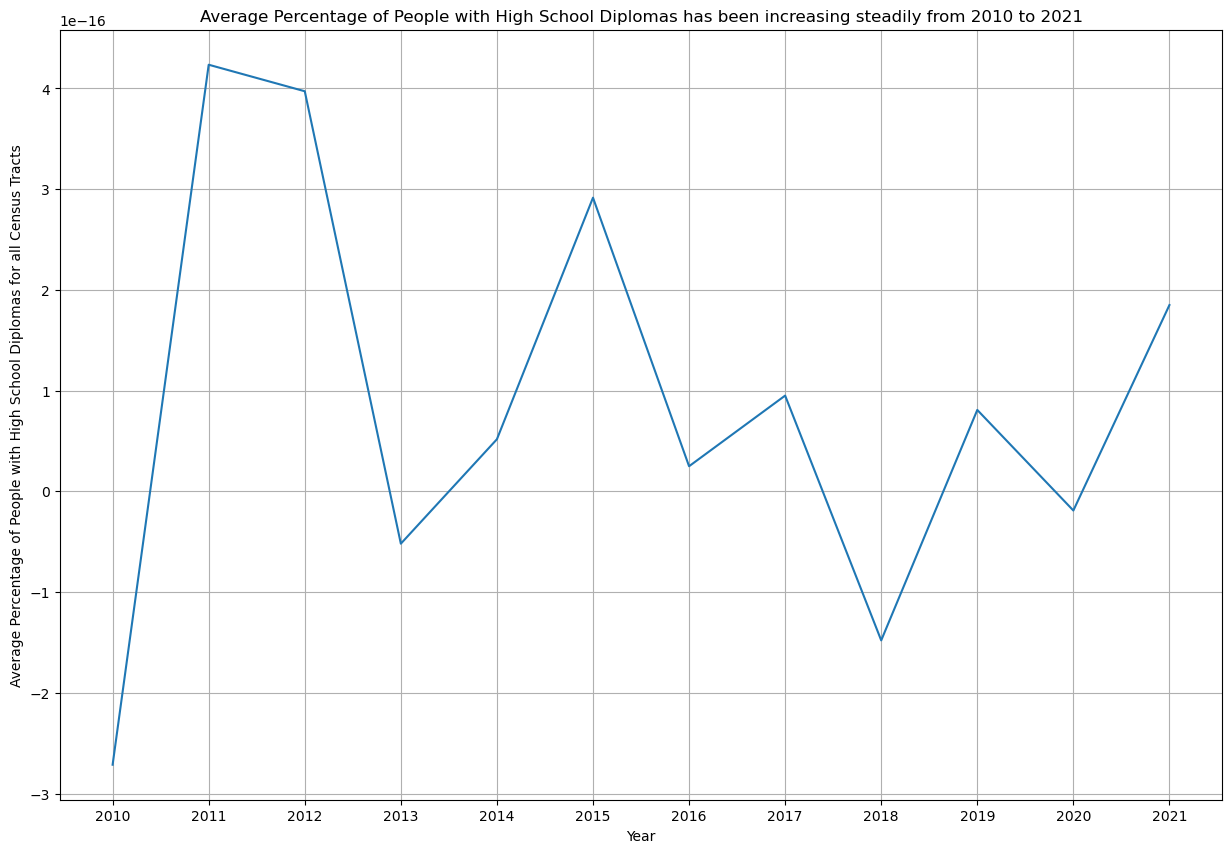

In [277]:
fig, ax = plt.subplots(figsize=(15,10))

sns.lineplot(data=df_combined.iloc[:,1:].mean(axis=0).rename('mean'),markers=True)
plt.title('Average Percentage of People with High School Diplomas has been increasing steadily from 2010 to 2021')
plt.xlabel('Year')
plt.ylabel('Average Percentage of People with High School Diplomas for all Census Tracts')

plt.xticks(range(0, len(school.columns)), [str(year) for year in range(2010,2022)])
plt.grid(True)
plt.show();

In [286]:
class_change=['gentrified' if (row['Combined_metric_2021']-row['Combined_metric_2010'])>0 else 'not_gentrified' for i,row in df_combined.iterrows()]
#abs_change_remap=abs_change+abs(min(abs_change))

fig = px.scatter_mapbox(coord(df_combined,ct_coord), lat="LATITUDE", lon="LONGITUDE",color=class_change,color_discrete_map={'not_gentrified': 'green', 'gentrified': 'red'},size=list(abs_change_remap**2), size_max=15, zoom=10, mapbox_style="carto-positron")

fig.update_layout(width=1500,height=1000)

fig.show()